In [1]:
!pip install pandas matplotlib openpyxl --quiet
print("Packages installed (or were already present).")

Packages installed (or were already present).


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

%matplotlib inline

plt.rcParams['figure.figsize'] = (10,5)

print("Imports done.")

Imports done.


In [3]:
excel_path = r"C:\Users\bhair\OneDrive\Desktop\1. Digital KYC Reduce Drop-Off Lift Conversion\Digital KYC_Reduce Drop-Off_Lift Conversion.xlsx"
sheet_name = "Digital KYC Data Dump"   # change only if the sheet tab name is different

out_dir = "dkcy_output"
os.makedirs(out_dir, exist_ok=True)

improvements = {
    'Document Scan': {'failure_reduction_pct': 0.35, 'time_reduction_pct': 0.40},
    'Upload Document': {'failure_reduction_pct': 0.25, 'time_reduction_pct': 0.30},
    'KYC Check': {'failure_reduction_pct': 0.20, 'time_reduction_pct': 0.25},
    'KYC Approval': {'failure_reduction_pct': 0.20, 'time_reduction_pct': 0.20},
    'Select Document Type': {'failure_reduction_pct': 0.15, 'time_reduction_pct': 0.10}
}

print("Configuration set. Output folder:", os.path.abspath(out_dir))

Configuration set. Output folder: C:\Users\bhair\dkcy_output


In [4]:
xls = pd.ExcelFile(excel_path)
df_raw = pd.read_excel(xls, sheet_name)

# Try to auto-map columns by keyword; fallback to positional mapping similar to provided file
cols = list(df_raw.columns)
col_map = {}
for c in cols:
    lc = str(c).lower()
    if 'customer' in lc:
        col_map[c] = 'CustomerID'
    elif 'stage' in lc:
        col_map[c] = 'StageName'
    elif 'attempt' in lc:
        col_map[c] = 'AttemptCount'
    elif 'failure' in lc:
        col_map[c] = 'FailurePct'
    elif 'time' in lc or 'seconds' in lc:
        col_map[c] = 'TimeTakenSec'
    elif 'error' in lc:
        col_map[c] = 'ErrorMsg'

# Fallback positional mapping if important columns missing
if len(col_map) < 4:
    try:
        col_map = {
            cols[1]: 'S.No',
            cols[2]: 'CustomerID',
            cols[3]: 'StageName',
            cols[4]: 'AttemptCount',
            cols[5]: 'FailurePct',
            cols[6]: 'TimeTakenSec',
            cols[7]: 'ErrorMsg'
        }
    except Exception as e:
        raise RuntimeError("Could not auto-map columns. Please open the Excel and check headers.") from e

df = df_raw.rename(columns=col_map)
# keep only mapped columns present in df
keep_cols = [v for v in col_map.values() if v in df.columns]
df = df[keep_cols]

# drop rows missing CustomerID (these are often header/repeat rows)
df = df[~df['CustomerID'].isna()]

# convert numeric columns
df['AttemptCount'] = pd.to_numeric(df['AttemptCount'], errors='coerce')
df['FailurePct'] = pd.to_numeric(df['FailurePct'], errors='coerce')
df['TimeTakenSec'] = pd.to_numeric(df['TimeTakenSec'], errors='coerce')
df['StageName'] = df['StageName'].astype(str).str.strip()

print("Loaded rows:", df.shape[0])
df.head(10)

Loaded rows: 401


,S.No,CustomerID,StageName,AttemptCount,FailurePct,TimeTakenSec,ErrorMsg
0,S.No.,Customer ID,Stage Name,NaN,NaN,NaN,Error
1,1,2815597,Upload Document,1.0,0.15,16.0,Upload the Selected Document
2,2,2738532,Document Scan,3.0,0.30,39.0,Please scan the correct document
3,3,4110529,Document Scan,2.0,0.20,25.0,Please scan the correct document
4,4,2992473,KYC Check,3.0,0.30,32.0,KYC data not found; please upload correct KYC
5,5,4205534,KYC Approved,1.0,0.00,15.0,KYC Successful
6,6,3980339,Select Document Type,3.0,0.15,28.0,Please select correct document type
7,7,3805421,Upload Document,2.0,0.40,26.0,Please upload the correct selected document
8,8,3677810,Document Scan,1.0,0.10,16.0,Proceed to Document Upload
9,9,2886682,KYC Check,3.0,0.60,38.0,KYC data not found; please upload correct KYC


In [5]:
failure_by_stage = df.groupby('StageName', dropna=False)['FailurePct'].mean().reset_index().sort_values('FailurePct', ascending=False)
failure_by_stage.columns = ['Stage', 'AvgFailurePct']

time_by_stage = df.groupby('StageName', dropna=False)['TimeTakenSec'].mean().reset_index().sort_values('TimeTakenSec', ascending=False)
time_by_stage.columns = ['Stage', 'AvgTimeSec']

attempts_dist = df['AttemptCount'].value_counts().sort_index().reset_index()
attempts_dist.columns = ['AttemptCount', 'Count']

high_attempts_count = df[df['AttemptCount'] >= 3].shape[0]

print("Failure % by Stage:")
display(failure_by_stage)
print("\nAverage Time (sec) by Stage:")
display(time_by_stage)
print("\nAttempts distribution:")
display(attempts_dist)
print("\nRows with AttemptCount >= 3:", high_attempts_count)

Failure % by Stage:


,Stage,AvgFailurePct
2,KYC Check,0.468333
5,Upload Document,0.241886
0,Document Scan,0.220714
3,Select Document Type,0.114167
1,KYC Approved,0.062500
4,Stage Name,NaN



Average Time (sec) by Stage:


,Stage,AvgTimeSec
2,KYC Check,33.150000
0,Document Scan,31.621429
3,Select Document Type,30.400000
1,KYC Approved,27.575000
5,Upload Document,27.560000
4,Stage Name,NaN



Attempts distribution:


,AttemptCount,Count
0,1.0,112
1,2.0,119
2,3.0,155
3,4.0,14



Rows with AttemptCount >= 3: 169


In [6]:
sim_rows = []
for _, row in failure_by_stage.iterrows():
    stage = row['Stage']
    base_fail = row['AvgFailurePct'] if not np.isnan(row['AvgFailurePct']) else 0.0
    base_time_arr = time_by_stage.loc[time_by_stage['Stage'] == stage, 'AvgTimeSec'].values
    base_time = base_time_arr[0] if len(base_time_arr)>0 and not np.isnan(base_time_arr[0]) else np.nan

    if stage in improvements:
        imp = improvements[stage]
        new_fail = max(base_fail * (1 - imp['failure_reduction_pct']), 0)
        new_time = base_time * (1 - imp['time_reduction_pct']) if not np.isnan(base_time) else np.nan
    else:
        new_fail = base_fail
        new_time = base_time

    sim_rows.append({
        'Stage': stage,
        'BaseFailurePct': base_fail,
        'SimFailurePct': new_fail,
        'BaseTimeSec': base_time,
        'SimTimeSec': new_time
    })

sim_df = pd.DataFrame(sim_rows).sort_values('BaseFailurePct', ascending=False)
print("Simulation (baseline vs simulated):")
display(sim_df)

Simulation (baseline vs simulated):


,Stage,BaseFailurePct,SimFailurePct,BaseTimeSec,SimTimeSec
0,KYC Check,0.468333,0.374667,33.150000,24.862500
1,Upload Document,0.241886,0.181415,27.560000,19.292000
2,Document Scan,0.220714,0.143464,31.621429,18.972857
3,Select Document Type,0.114167,0.097042,30.400000,27.360000
4,KYC Approved,0.062500,0.062500,27.575000,27.575000
5,Stage Name,0.000000,0.000000,NaN,NaN


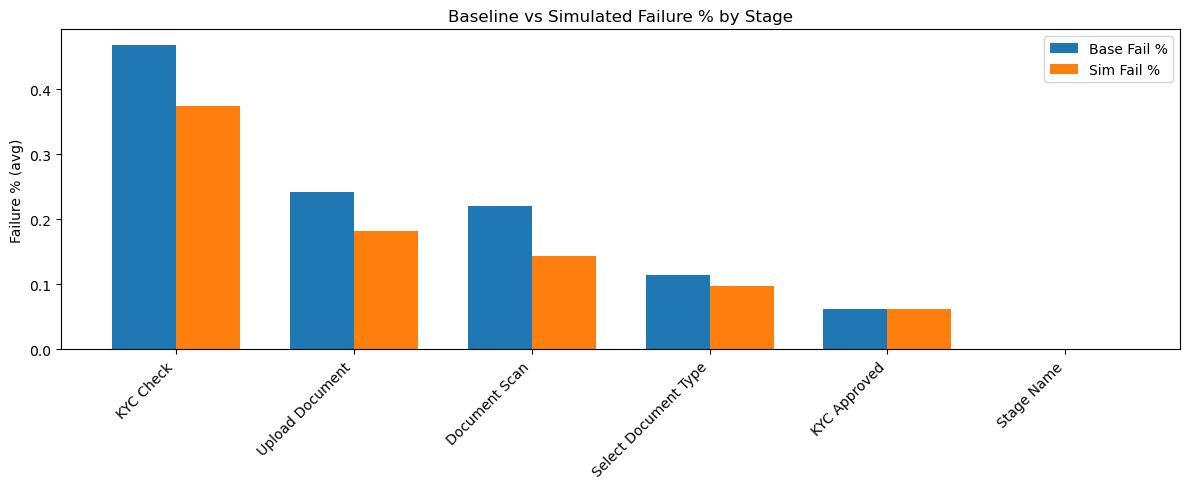

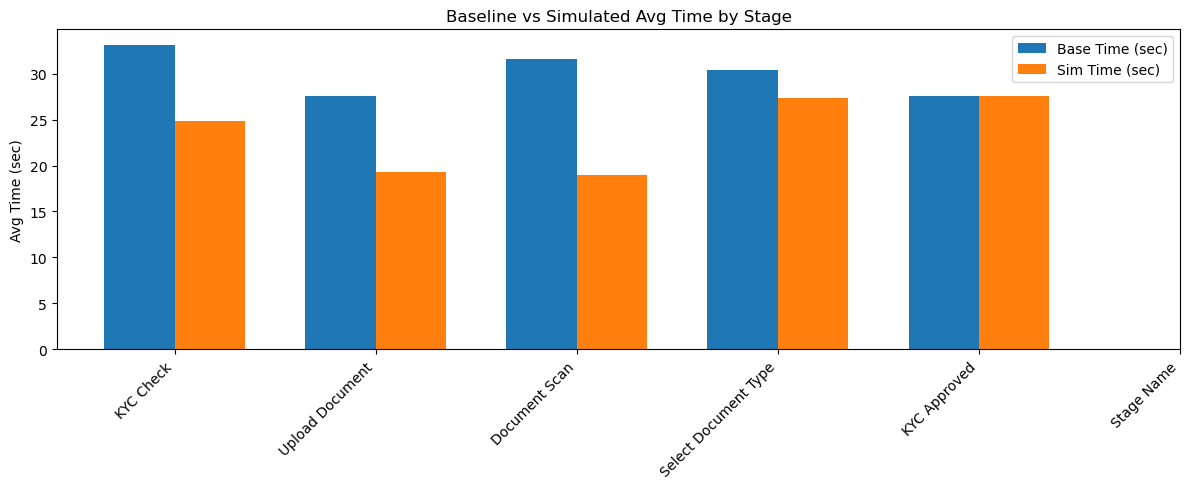

Saved CSVs and PNGs to: C:\Users\bhair\dkcy_output


,Stage,Count,EstimatedBaseFailures,EstimatedSimFailures,FailuresReduced
0,Document Scan,140,30.900000,20.085000,10.815000
1,KYC Approved,40,2.500000,2.500000,0.000000
2,KYC Check,60,28.100000,22.480000,5.620000
3,Select Document Type,60,6.850000,5.822500,1.027500
4,Stage Name,1,0.000000,0.000000,0.000000
5,Upload Document,100,24.188607,18.141456,6.047152


In [7]:
# Impact estimation and saving outputs
counts_by_stage = df.groupby('StageName').size().reset_index(name='Count').rename(columns={'StageName':'Stage'})
impact = counts_by_stage.merge(sim_df, on='Stage', how='left')
impact['EstimatedBaseFailures'] = impact['Count'] * impact['BaseFailurePct']
impact['EstimatedSimFailures'] = impact['Count'] * impact['SimFailurePct']
impact['FailuresReduced'] = impact['EstimatedBaseFailures'] - impact['EstimatedSimFailures']

# save CSVs
failure_by_stage.to_csv(os.path.join(out_dir, 'baseline_failure_by_stage.csv'), index=False)
time_by_stage.to_csv(os.path.join(out_dir, 'baseline_time_by_stage.csv'), index=False)
sim_df.to_csv(os.path.join(out_dir, 'simulated_stage_summary.csv'), index=False)
impact.to_csv(os.path.join(out_dir, 'impact_estimates.csv'), index=False)

# plot - failure %
x = np.arange(len(sim_df))
plt.figure(figsize=(12,5))
plt.bar(x - 0.18, sim_df['BaseFailurePct'], width=0.36, label='Base Fail %')
plt.bar(x + 0.18, sim_df['SimFailurePct'], width=0.36, label='Sim Fail %')
plt.xticks(x, sim_df['Stage'], rotation=45, ha='right')
plt.ylabel('Failure % (avg)')
plt.title('Baseline vs Simulated Failure % by Stage')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(out_dir, 'failure_pct_comparison.png'))
plt.show()

# plot - time
ind = np.arange(len(sim_df))
width = 0.35
plt.figure(figsize=(12,5))
plt.bar(ind, sim_df['BaseTimeSec'], width, label='Base Time (sec)')
plt.bar(ind + width, sim_df['SimTimeSec'], width, label='Sim Time (sec)')
plt.xticks(ind + width/2, sim_df['Stage'], rotation=45, ha='right')
plt.ylabel('Avg Time (sec)')
plt.title('Baseline vs Simulated Avg Time by Stage')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(out_dir,'time_comparison.png'))
plt.show()

print("Saved CSVs and PNGs to:", os.path.abspath(out_dir))
display(impact[['Stage','Count','EstimatedBaseFailures','EstimatedSimFailures','FailuresReduced']])

In [8]:
total_base_failures = impact['EstimatedBaseFailures'].sum()
total_sim_failures = impact['EstimatedSimFailures'].sum()
reduction = total_base_failures - total_sim_failures
reduction_pct = (reduction / total_base_failures * 100) if total_base_failures>0 else 0.0

print("TOTAL RECORDS (sample):", df.shape[0])
print("Estimated total base failures:", float(total_base_failures))
print("Estimated total simulated failures:", float(total_sim_failures))
print("Estimated failures reduced:", float(reduction))
print("Estimated % reduction in failures: {:.1f}%".format(reduction_pct))
print("Rows with AttemptCount >=3:", int(high_attempts_count))

TOTAL RECORDS (sample): 401
Estimated total base failures: 92.53860735546019
Estimated total simulated failures: 69.02895551659515
Estimated failures reduced: 23.50965183886504
Estimated % reduction in failures: 25.4%
Rows with AttemptCount >=3: 169
